In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

path = "/content/gdrive/My Drive/Datasets/MNIST/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random as r

def breaker():
    print("\n" + 50*"-" + "\n")

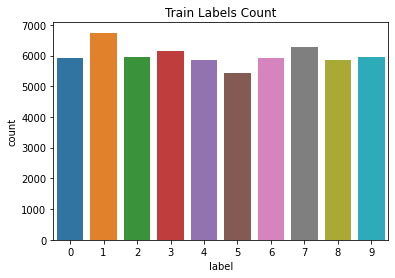

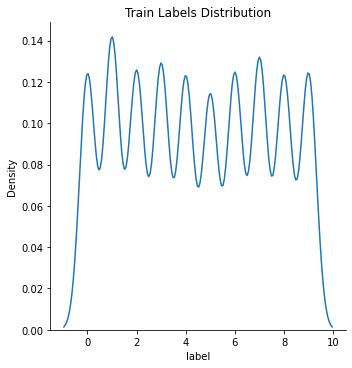

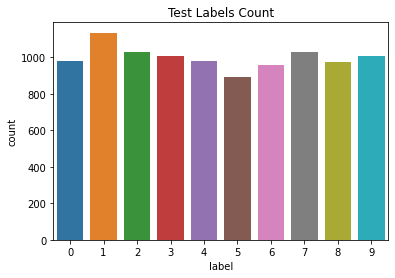

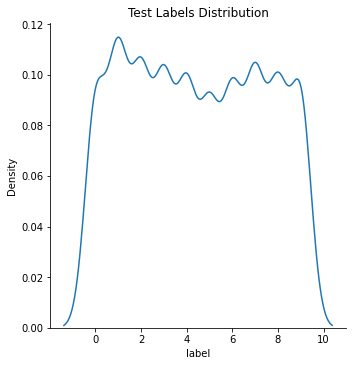

In [3]:
tr_set = pd.read_csv(path + "train.csv")
ts_set = pd.read_csv(path + "test.csv")

plt.figure()
sns.countplot(data=tr_set, x="label")
plt.title("Train Labels Count")
plt.show()
sns.displot(tr_set["label"], kind="kde")
plt.title("Train Labels Distribution")
plt.show()

plt.figure()
sns.countplot(data=ts_set, x="label")
plt.title("Test Labels Count")
plt.show()
sns.displot(ts_set["label"], kind="kde")
plt.title("Test Labels Distribution")
plt.show()

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(tr_set.iloc[:, 1:].copy().values,
                                                      tr_set.iloc[:, 0].copy().values,
                                                      shuffle=True,
                                                      random_state=0,
                                                      stratify=tr_set.iloc[:, 0].copy().values) 

X_test, y_test = ts_set.iloc[:, 1:].copy().values, ts_set.iloc[:, 0].copy().values

MAX_VALUE = 255

X_train = np.divide(X_train, MAX_VALUE)
X_valid = np.divide(X_valid, MAX_VALUE)
X_test  = np.divide(X_test, MAX_VALUE)

del tr_set, ts_set

print("Garbage Collected : {}".format(gc.collect()))

Garbage Collected : 11040


# Setup

In [5]:
class Dataset(Dataset):
    def __init__(this, X=None, y=None):
        this.X = X.reshape(X.shape[0], 1, 28, 28)
        this.y = y

    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        return torch.FloatTensor(this.X[idx]), torch.LongTensor(this.y[idx])

In [6]:
class CFG():
    tr_batch_size = 128
    va_batch_size = 128
    ts_batch_size = 128

    ae_epochs = 25
    cl_epochs = 25

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __init__(this, code_size):
        this.code_size = code_size

cfg = CFG(code_size=2048)

tr_data_setup = Dataset(X_train, y_train.reshape(-1, 1))
va_data_setup = Dataset(X_valid, y_valid.reshape(-1, 1))
ts_data_setup = Dataset(X_test, y_test.reshape(-1, 1))

DLS = {
       "train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
       "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False),
       "test"  : DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)
      }

In [7]:
def fit_(model=None, optimizer=None, scheduler=None, epochs=None, 
             trainloader=None, validloader=None, 
             criterion=None, device=None, 
             classify=False, verbose=False):
    
    breaker()
    print("Training ...")
    breaker()

    model.to(device)
    LPT = []
    LPV = []
    start_time = time()
    for e in range(epochs):
        trainLossPerPass = 0
        validLossPerPass = 0

        model.train()
        for X, y in trainloader:
            X = X.to(device)
            if classify:
                y = y.to(device).view(-1)
                optimizer.zero_grad()
                output = model(X)
                loss = criterion(output, y)
                loss.backward()
                trainLossPerPass += (loss.item() / y.shape[0])
                optimizer.step()
            else:
                optimizer.zero_grad()
                _, output = model(X)
                loss = criterion(output, X)
                loss.backward()
                trainLossPerPass += (loss.item() / X.shape[0])
                optimizer.step()
        LPT.append(trainLossPerPass)

        model.eval()
        for X, y in validloader:
            X = X.to(device)
            if classify:
                y = y.to(device).view(-1)
                with torch.no_grad():
                    output = model(X)
                    loss = criterion(output, y)
                    validLossPerPass += (loss.item() / y.shape[0])
            else:
                with torch.no_grad():
                    _, output = model(X)
                    loss = criterion(output, X)
                    validLossPerPass += (loss.item() / X.shape[0])
        LPV.append(validLossPerPass)

        if scheduler:
            scheduler.step()
        
        if verbose:
            print("Epoch : {} | Training Loss : {:.5f} | Validation Loss : {:.5f}".format(e+1, trainLossPerPass, validLossPerPass))    

    breaker()
    print("Time Taken [{} Epochs] : {:.2f} minutes".format(epochs, (time()-start_time)/60))
    breaker()
    print("Training Complete")
    breaker()

    return LPT, LPV


def predict_(model=None, dataloader=None, batch_size=None, device=None, path=None):
    y_pred = torch.zeros(batch_size, 1).to(device)

    model.eval()

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            Prob = torch.exp(model(X))
        Pred = torch.argmax(Prob, dim=1)
        y_pred = torch.cat((y_pred, Pred.view(-1, 1)), dim=0)
    return y_pred[batch_size:].detach().cpu().numpy().reshape(-1).astype(int)

# Autoencoder

In [8]:
class CAE(nn.Module):
    def __init__(this, code_size=None):
        super().__init__()

        this.encoder = nn.Sequential()
        this.encoder.add_module("Convolution 1", nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 1", nn.BatchNorm2d(num_features=64))
        this.encoder.add_module("MaxPool 1", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 1", nn.ReLU())
        this.encoder.add_module("Convolution 2", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 2", nn.BatchNorm2d(num_features=128))
        this.encoder.add_module("MaxPool 2", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 2", nn.ReLU())
        this.encoder.add_module("Convolution 3", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 3", nn.BatchNorm2d(num_features=256))
        this.encoder.add_module("MaxPool 3", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 3", nn.ReLU())

        this.decoder = nn.Sequential()
        this.decoder.add_module("Deconvolution 1", nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2))
        this.decoder.add_module("Activation 1", nn.ReLU())
        this.decoder.add_module("Deconvolution 2", nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2))
        this.decoder.add_module("Activation 2", nn.ReLU())
        this.decoder.add_module("Deactivation 3", nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=2, stride=2))
        this.decoder.add_module("Activation 3", nn.Sigmoid())

    def getOptimizer(this, lr=1e-3, wd=0):
        return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)

    def forward(this, x):
        encoded = this.encoder(x)
        x = this.decoder(encoded)
        return encoded, x


--------------------------------------------------

Training ...

--------------------------------------------------

Epoch : 1 | Training Loss : 0.03898 | Validation Loss : 0.00409
Epoch : 2 | Training Loss : 0.00948 | Validation Loss : 0.00285
Epoch : 3 | Training Loss : 0.00715 | Validation Loss : 0.00240
Epoch : 4 | Training Loss : 0.00616 | Validation Loss : 0.00190
Epoch : 5 | Training Loss : 0.00561 | Validation Loss : 0.00185
Epoch : 6 | Training Loss : 0.00494 | Validation Loss : 0.00197
Epoch : 7 | Training Loss : 0.00451 | Validation Loss : 0.00160
Epoch : 8 | Training Loss : 0.00424 | Validation Loss : 0.00153
Epoch : 9 | Training Loss : 0.00401 | Validation Loss : 0.00146
Epoch : 10 | Training Loss : 0.00386 | Validation Loss : 0.00135
Epoch : 11 | Training Loss : 0.00357 | Validation Loss : 0.00121
Epoch : 12 | Training Loss : 0.00343 | Validation Loss : 0.00128
Epoch : 13 | Training Loss : 0.00327 | Validation Loss : 0.00114
Epoch : 14 | Training Loss : 0.00307 | Valida

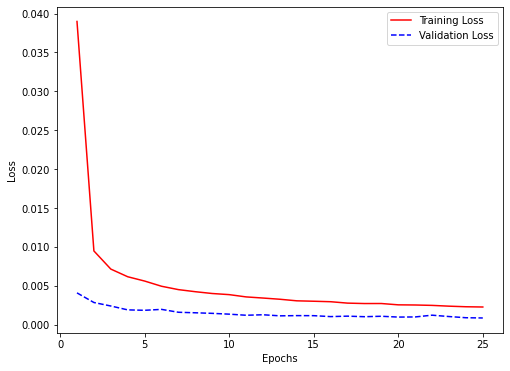

In [9]:
torch.manual_seed(0)
cae_model = CAE(code_size=cfg.code_size)
cae_optimizer = cae_model.getOptimizer(lr=1e-3, wd=0)

LPT, LPV = fit_(model=cae_model, optimizer=cae_optimizer, epochs=cfg.ae_epochs,
                trainloader=DLS["train"], validloader=DLS["valid"],
                criterion=nn.MSELoss(), device=cfg.device,
                verbose=True)

plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(LPT))], LPT, "r", label="Training Loss")
plt.plot([i+1 for i in range(len(LPV))], LPV, "b--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

**Evaluation**

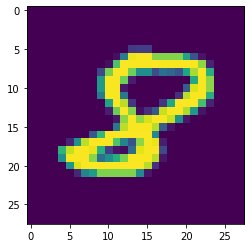

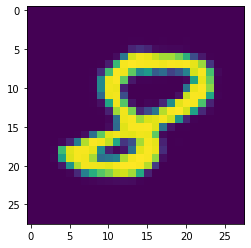

In [10]:
ts_x, ts_y = next(iter(DLS["test"]))

sample_no = r.randint(0, cfg.ts_batch_size)
plt.figure()
plt.imshow(ts_x[sample_no, 0, :, :].detach().cpu().numpy())
plt.show()

cae_model.eval()
_, recon_image = cae_model(ts_x.to(cfg.device))

plt.figure()
plt.imshow(recon_image[sample_no, 0, :, :].detach().cpu().numpy())
plt.show()

for names, params in cae_model.named_parameters():
    params.requires_grad = False

# Classification

In [11]:
class CNN(nn.Module):
    def __init__(this, code_size=None):
        super().__init__()

        this.encoder = nn.Sequential()
        this.encoder.add_module("Convolution 1", nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 1", nn.BatchNorm2d(num_features=64))
        this.encoder.add_module("MaxPool 1", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 1", nn.ReLU())
        this.encoder.add_module("Convolution 2", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 2", nn.BatchNorm2d(num_features=128))
        this.encoder.add_module("MaxPool 2", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 2", nn.ReLU())
        this.encoder.add_module("Convolution 3", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 3", nn.BatchNorm2d(num_features=256))
        this.encoder.add_module("MaxPool 3", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 3", nn.ReLU())

        this.FC1 = nn.Linear(in_features=256*3*3, out_features=2048)
        this.FC2 = nn.Linear(in_features=2048, out_features=10)

    def getOptimizer(this, lr=1e-3, wd=0):
        return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)

    def forward(this, x):
        x = this.encoder(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(this.FC1(x))
        x = F.log_softmax(this.FC2(x), dim=1)
        return x

In [12]:
torch.manual_seed(0)
cnn_model = CNN(code_size=cfg.code_size)

for names, params in cnn_model.named_parameters():
    params = cae_model.state_dict()[names]
    if names == "encoder.BatchNorm 3.bias":
        break
    
for names, params in cnn_model.named_parameters():
    params.requires_grad = False
    if names == "encoder.BatchNorm 3.bias":
        break


--------------------------------------------------

Training ...

--------------------------------------------------

Epoch : 1 | Training Loss : 0.95941 | Validation Loss : 0.08620
Epoch : 2 | Training Loss : 0.22891 | Validation Loss : 0.07592
Epoch : 3 | Training Loss : 0.16227 | Validation Loss : 0.07586
Epoch : 4 | Training Loss : 0.12763 | Validation Loss : 0.07383
Epoch : 5 | Training Loss : 0.12429 | Validation Loss : 0.06407
Epoch : 6 | Training Loss : 0.09945 | Validation Loss : 0.05615
Epoch : 7 | Training Loss : 0.09611 | Validation Loss : 0.06811
Epoch : 8 | Training Loss : 0.07555 | Validation Loss : 0.06755
Epoch : 9 | Training Loss : 0.06996 | Validation Loss : 0.07803
Epoch : 10 | Training Loss : 0.05105 | Validation Loss : 0.11217
Epoch : 11 | Training Loss : 0.05281 | Validation Loss : 0.09559
Epoch : 12 | Training Loss : 0.06827 | Validation Loss : 0.06609
Epoch : 13 | Training Loss : 0.04401 | Validation Loss : 0.04576
Epoch : 14 | Training Loss : 0.03786 | Valida

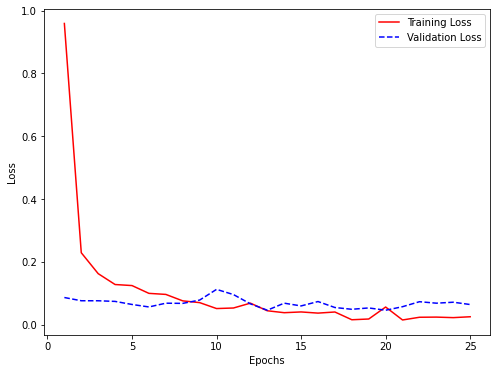

In [13]:
cnn_optimizer = cnn_model.getOptimizer(lr=1e-3, wd=0)

LPT, LPV = fit_(model=cnn_model, optimizer=cnn_optimizer, epochs=cfg.cl_epochs,
                trainloader=DLS["train"], validloader=DLS["valid"],
                criterion=nn.NLLLoss(), device=cfg.device, classify=True,
                verbose=True)
 
plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(LPT))], LPT, "r", label="Training Loss")
plt.plot([i+1 for i in range(len(LPV))], LPV, "b--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

**Evaluation**

In [14]:
y_pred = predict_(model=cnn_model, dataloader=DLS["test"], batch_size=cfg.ts_batch_size, device=cfg.device)

breaker()
print("Classification Accuracy : {:.5f} %".format(accuracy_score(y_test, y_pred) * 100))
breaker()


--------------------------------------------------

Classification Accuracy : 98.48000 %

--------------------------------------------------

